# Shapley Values

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.datasets import make_classification
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_log_error
from sklearn import tree
from IPython.display import Image  
from sklearn.inspection import PartialDependenceDisplay
from sklearn.base import is_classifier, is_regressor
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn import tree
from IPython.display import Image  
from numpy import linalg
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from time import time
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
import random
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.base import is_classifier, is_regressor
import seaborn as sns
import math


In [2]:
import shap
import xgboost

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### Shapley Values

Suppose thay we have three players: A, B, and C. They will play a cooperative game and will obtain a certain gain. Players' individual contribution might be different. We want to calculate the marginal conributions of each player in order to distribute the gain according to their marginal contributions. How can we do it?

The basic idea is to find the marginal contribution of a player, say A, according to the gains in games where A is present and where A is not.




Shapley value:

$$
\phi_i(v) = \sum_{\substack{S \subseteq N \backslash \{i\} }} \frac{(n - |S| - 1)! \cdot |S|!}{n!} \left( v(S \cup \{i\}) - v(S) \right) 
$$

where:
- $ \phi_i(v) $ represents the Shapley value of player $i$ in the game $v$,
- $ N $ is the set of all players,
- $ S $ is a coalition of players,
- $ n $ is the total number of players, and
- $ v(S) $ denotes the worth of coalition $S$.

The weight 
$$
\frac{(n - |S| - 1)! \cdot |S|!}{n!}
$$

might look complicated but it is simply the fraction of cases, among all permutations, where player $i$ enters the coalition after the set $S$ is formed. The set $S$ can be arranged in $|S|!$ many different ways, then we add the player $i$, and the remaining players can be arranged in $(n - |S| - 1)!$ many ways.

You might think of other formulations for calculating the contribution of a player, this particular one has some nice properties: efficiency, symmetry, linearity, and null player. This part will be extended later.

### Below is an example of classical Shapely value calculation:

In [3]:
import math
import itertools

def calculate_shapley_value(player, player_list, characteristic_function):
    n = len(player_list)
    shapley_value = 0

    for permutation in itertools.permutations(player_list):
        print("Order:", permutation)
        coalition = []
        coalition_value = 0

        for p in permutation:
            if p == player:
                break
            else:
                coalition.append(p)
                
        coalition_value = characteristic_function(coalition)
        coalition.append(player)
        coalition_value_with_player = characteristic_function(coalition)

        marginal_contribution = coalition_value_with_player - coalition_value
        print("Marginal contribution of ", player, ": ",marginal_contribution)
        shapley_value += marginal_contribution / math.factorial(n)

    return shapley_value

# Example characteristic function
def characteristic_function(coalition):
    # Define the characteristic function here
    if len(coalition) == 0:
        return 0
    elif len(coalition) == 1:
        player = coalition[0]
        if player == 'A':
            return 100
        elif player == 'B':
            return 125
        elif player == 'C':
            return 50
    elif len(coalition) == 2:
        if 'A' in coalition and 'B' in coalition:
            return 270
        elif 'A' in coalition and 'C' in coalition:
            return 375
        elif 'B' in coalition and 'C' in coalition:
            return 350
    elif len(coalition) == 3:
        return 500

# Player list
player_list = ['A', 'B', 'C']

# Calculate Shapley values for each player
shapley_values = {}
for player in player_list:
    shapley_values[player] = calculate_shapley_value(player, player_list, characteristic_function)

# Print the Shapley values
for player, value in shapley_values.items():
    print(f"The Shapley value for player {player} is: {value}")


Order: ('A', 'B', 'C')
Marginal contribution of  A :  100
Order: ('A', 'C', 'B')
Marginal contribution of  A :  100
Order: ('B', 'A', 'C')
Marginal contribution of  A :  145
Order: ('B', 'C', 'A')
Marginal contribution of  A :  150
Order: ('C', 'A', 'B')
Marginal contribution of  A :  325
Order: ('C', 'B', 'A')
Marginal contribution of  A :  150
Order: ('A', 'B', 'C')
Marginal contribution of  B :  170
Order: ('A', 'C', 'B')
Marginal contribution of  B :  125
Order: ('B', 'A', 'C')
Marginal contribution of  B :  125
Order: ('B', 'C', 'A')
Marginal contribution of  B :  125
Order: ('C', 'A', 'B')
Marginal contribution of  B :  125
Order: ('C', 'B', 'A')
Marginal contribution of  B :  300
Order: ('A', 'B', 'C')
Marginal contribution of  C :  230
Order: ('A', 'C', 'B')
Marginal contribution of  C :  275
Order: ('B', 'A', 'C')
Marginal contribution of  C :  230
Order: ('B', 'C', 'A')
Marginal contribution of  C :  225
Order: ('C', 'A', 'B')
Marginal contribution of  C :  50
Order: ('C', 'B

In [4]:
import math
import itertools

def calculate_shapley_value(player, player_list, characteristic_function):
    n = len(player_list)
    shapley_value = 0

    for permutation in itertools.permutations(player_list):
        print("Order:", permutation)
        coalition = []
        coalition_value = 0

        for p in permutation:
            if p == player:
                break
            else:
                coalition.append(p)
        coalition_value = characteristic_function[tuple(sorted(coalition))]
        coalition.append(player)
        coalition_value_with_player = characteristic_function[tuple(sorted(coalition))]

        marginal_contribution = coalition_value_with_player - coalition_value
        print("Marginal contribution of ", player, ": ",marginal_contribution)
        shapley_value += marginal_contribution / math.factorial(n)

    return shapley_value

# Example characteristic function as a dictionary
characteristic_function = {
    (): 0,
    (1,): 100,
    (2,): 125,
    (3,): 50,
    (1, 2): 270,
    (1, 3): 375,
    (2, 3): 350,
    (1, 2, 3): 500
}

# Player list
player_list = [1, 2, 3]

# Calculate Shapley values for each player
shapley_values = {}
for player in player_list:
    shapley_values[player] = calculate_shapley_value(player, player_list, characteristic_function)

# Print the Shapley values
for player, value in shapley_values.items():
    print(f"The Shapley value for player {player} is: {value}")


Order: (1, 2, 3)
Marginal contribution of  1 :  100
Order: (1, 3, 2)
Marginal contribution of  1 :  100
Order: (2, 1, 3)
Marginal contribution of  1 :  145
Order: (2, 3, 1)
Marginal contribution of  1 :  150
Order: (3, 1, 2)
Marginal contribution of  1 :  325
Order: (3, 2, 1)
Marginal contribution of  1 :  150
Order: (1, 2, 3)
Marginal contribution of  2 :  170
Order: (1, 3, 2)
Marginal contribution of  2 :  125
Order: (2, 1, 3)
Marginal contribution of  2 :  125
Order: (2, 3, 1)
Marginal contribution of  2 :  125
Order: (3, 1, 2)
Marginal contribution of  2 :  125
Order: (3, 2, 1)
Marginal contribution of  2 :  300
Order: (1, 2, 3)
Marginal contribution of  3 :  230
Order: (1, 3, 2)
Marginal contribution of  3 :  275
Order: (2, 1, 3)
Marginal contribution of  3 :  230
Order: (2, 3, 1)
Marginal contribution of  3 :  225
Order: (3, 1, 2)
Marginal contribution of  3 :  50
Order: (3, 2, 1)
Marginal contribution of  3 :  50
The Shapley value for player 1 is: 161.66666666666666
The Shapley 

### Local Explanation

Situational Importance: Given a model $f$ and an instance $x$, the situational importance of $x_i$, the situational importance of the $ith$ feature, is defined as follows:

$$
\varphi_i(x) = f(x_1,...,x_n) - E[f(x_1,...X_i,...,x_n)]
$$

This formulation might be a bit challenging to comprehend. The challenge is to define the prediction value in the absence of a feature. First of all, this is a local explanation, that is, it is not the (global) importance of the feature $i$. It tries to capture the importance of a particular value of the feature $i$ in the context of a particular instance. Let us use an example. Suppose that we have model for house price prediction. Suppose that the model is: 
$$
f(x) = 100000 + 1000 \times area - 5000 \times age
$$

and suppose that $x$ is a house with $area = 200$ and $age = 10$. For this particular house the model's prediction will be $100000 + 1000\times200 - 5000\times10 = 250000$. What is the importance of the area to be $200$ for this prediction? To calculate this importance, according to situational importance, we need to calculate the expected value of the prediction over all possible values of the area feature which is simply the average value of the predictions using all possible values of the area feature and holding the other features' (only age in this example) values fixed. 

Note that this type of importance is different from global importance of a feature. In the case of the above linear model, one might tend to think that, for all predictions, the contribution of the area feature is fixed and is given by its coefficient, which is 1000 per unit area. However, according to situational importance, the contribution of the area feature for a specific instance is calculated relative to predictions using other area values. For example, if the area value for an instance happens to be the average area of all houses then the contribution of the area feature for that instance will be 0 (note that this is only true for linear models).

The SHAP value extends this situational importance to cover all feature subsets. Then, a feature's contribution to the prediction is the average of marginal contributions over all possible feature combinations. Note that this average over all feature combinations makes sense since a feature's contribution to different feature subsets might be different. 

The next problem is to define the value of $v(S)$, that is, the prediction value in the absence of a set of features. This is defined similar to situational importance as conditional expectation:

$$
v_x(S) = E[f(X)| X_s = x_s]
$$

Intutively, $v_x(S)$ is the expected prediction of $f$ for the instance $x$ conditioned on the features in $S$. To calculate this we marginalize over all the features which are not in $S$. That is, this is the average prediction over all possible values of the features not in $S$.

### Linear Model

For linear models it is easier to calculate SHAP values. Suppose that we have a linear model such as the one below:

$$
f(x) = \beta_0 + \beta_1x_1 + \beta_2x_2 +, ..., + \beta_nx_n
$$

According to the definition, $\phi_i(f)$, the shapley value of feature $i$, for a given instance $x$ is the weighted sum of the following terms:
$$
v_x(S \cup \{i\}) - v_x(S)
$$

where $S \subseteq N \backslash \{i\} $

and given that the definition of the value function is:
$$
v_x(S) = E[f(X)| X_s = x_s]
$$
then the following holds for all $S \subseteq N \backslash \{i\} $
$$
v_x(S \cup \{i\}) - v_x(S) = \beta_ix_i - E[\beta_iX_i] = \beta_ix_i - \beta_iE[X_i]
$$

Since the weight sum to 1,
$$
\phi_i(f) = \beta_ix_i - \beta_iE[X_i]
$$

Here is an example to test out intuitiosn about this result: Suppose that we have a house price prediction problem and after training we have the following model:

$$
price(house) = 100 + 5*area - 3*age
$$

Suppose that the instance, x, we have is: <area = 100, age = 12>. What is the contribution (Shapley value) of the area feature in the prediction for this instance. You might tend to think that since the coefficient of area is 5 the contribution of the area feature in this example is 5*100 = 500. But it is not (according to Shapley value approach). According to Shapley value approach what is important is the marginal contribution of the area feature. And the marginal contribution is measured as $\beta_ix_i - \beta_iE[X_i]$. Hence marginal contribution depends on the expected value of area. For example, if the average area values is 100 then the Shapley value of area for this instance will be 0.

Can we apply this to the churn problem.


If we sum up the Shapley value of all features,

$$
\sum_{i=1}^{n}\phi_i(f) = \sum_{i=1}^{n}\beta_ix_i - \sum_{i=1}^{n}\beta_iE[X_i] \\
= (\beta_0 + \sum_{i=1}^{n}\beta_ix_i) - (\beta_0 + \sum_{i=1}^{n}\beta_iE[X_i]) \\
= f(x) - E[X]
$$

which implies that,

$$
f(x) = \sum_{i=1}^{n}\phi_i(f)+ E[X]
$$



### Least Squares Solution

In [5]:
def kernel_weights(M,S):
    if (math.comb(M, len(S)) * len(S) * (M-len(S))) == 0:
        return 1000
    else:
        return (M - 1)/ (math.comb(M, len(S)) * len(S) * (M-len(S)))

In [6]:
def generate_binary_matrix(k):
    # Calculate the total number of rows (2^k)
    num_rows = 2**k

    # Generate binary numbers and populate the matrix
    binary_matrix = np.zeros((num_rows, k), dtype=int)
    for i in range(num_rows):
        binary_matrix[i] = [int(x) for x in format(i, f'0{k}b')]

    return binary_matrix


In [7]:
generate_binary_matrix(4)

array([[0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 1],
       [0, 1, 1, 0],
       [0, 1, 1, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 1],
       [1, 0, 1, 0],
       [1, 0, 1, 1],
       [1, 1, 0, 0],
       [1, 1, 0, 1],
       [1, 1, 1, 0],
       [1, 1, 1, 1]])

In [8]:
# Define the characteristic function (dictionary representation)
characteristic_function = {
    (): 0,
    (1,): 100,
    (2,): 125,
    (3,): 50,
    (1, 2): 270,
    (1, 3): 375,
    (2, 3): 350,
    (1, 2, 3): 500
}

# Number of players
num_players = 3

X = generate_binary_matrix(num_players)
y = []
w = []
for i in range(X.shape[0]):
    y.append(characteristic_function[tuple(sorted(np.where(X[i,:] == 1)[0]+1))])
    w.append(kernel_weights(num_players,np.where(X[i,:] == 1)[0] ))

lm = LinearRegression()
lm.fit(X,y, sample_weight=w)
print(lm.coef_)

[161.67481391 161.67481391 176.67481391]


### Shapley value calculation from scratch with sampling

The following code makes a local explanation. The algorithm is as follows:

To calculate the Shapley value for the feature $f_j$ in the prediction for instance $i$:

- for m = 1 to M do:
    - Sample a random subset of features $S_f$ such that $f_j \not\in S_f$.
    - Calculate the marginal contribution of $f_j$ by finding the difference between the prediction with features $S_f + f_j$ and features $S_f$.
    
The average marginal contribution will give the shapely value. This is not exact calculation but will approximate it. Marginalization is done by sampling random data points (aka Monte Carlo method). This is illustrated in the following code.



In [9]:
def shapley_value_by_sampling(model, X, instance_idx, feature_idx, n_iters = 1000):
    
    marginal_contributions = []

    n_features = X.shape[1]
    feature_idxs = list(range(n_features))
    x = X.iloc[instance_idx]
    feature_idxs.remove(feature_idx)

    for _ in range(n_iters):
        r = X.sample(1).values[0]

        # sample S_f
        S_f = random.sample(feature_idxs, random.randint(0,n_features-1))

        x_with_feature = np.array([x[i] if i in S_f + [feature_idx] else r[i] for i in range(n_features)]).reshape(1, -1)
        x_with_feature = pd.DataFrame(x_with_feature, columns=X.columns)
        x_without_feature = np.array([x[i] if i in S_f else r[i] for i in range(n_features)]).reshape(1, -1)
        x_without_feature = pd.DataFrame(x_without_feature, columns=X.columns)

        if (is_classifier(model)):
            marginal_contribution = model.predict_proba(x_with_feature)[0][1] - model.predict_proba(x_without_feature)[0][1]
        else:
            marginal_contribution = model.predict(x_with_feature) - model.predict(x_without_feature)

        marginal_contributions.append(marginal_contribution)
        
    shapley_value = sum(marginal_contributions) / len(marginal_contributions)  
    return X.columns[feature_idx], shapley_value


Let us now try this code on a data set.


### Census Income Dataset

In [10]:
adult = pd.read_csv("../../datasets/adult/adult.csv", delimiter=",", skipinitialspace=True)
print("Adult Shape:", adult.shape)
adult.head(5)

Adult Shape: (32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [11]:
adult.describe(include="all")

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y
count,32561.000000,32561,3.256100e+04,32561,32561.000000,32561,32561,32561,32561,32561,32561.000000,32561.000000,32561.000000,32561,32561
unique,NaN,9,NaN,16,NaN,7,15,6,5,2,NaN,NaN,NaN,42,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,22696,NaN,10501,NaN,14976,4140,13193,27816,21790,NaN,NaN,NaN,29170,24720
mean,38.581647,NaN,1.897784e+05,NaN,10.080679,NaN,NaN,NaN,NaN,NaN,1077.648844,87.303830,40.437456,NaN,NaN
std,13.640433,NaN,1.055500e+05,NaN,2.572720,NaN,NaN,NaN,NaN,NaN,7385.292085,402.960219,12.347429,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.178270e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.783560e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.370510e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


In [12]:
oe = OrdinalEncoder()
data = oe.fit_transform(adult)
ord_encoded = pd.DataFrame(data = data, columns = adult.columns)
ord_encoded

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y
0,22.0,7.0,2671.0,9.0,12.0,4.0,1.0,1.0,4.0,1.0,25.0,0.0,39.0,39.0,0.0
1,33.0,6.0,2926.0,9.0,12.0,2.0,4.0,0.0,4.0,1.0,0.0,0.0,12.0,39.0,0.0
2,21.0,4.0,14086.0,11.0,8.0,0.0,6.0,1.0,4.0,1.0,0.0,0.0,39.0,39.0,0.0
3,36.0,4.0,15336.0,1.0,6.0,2.0,6.0,0.0,2.0,1.0,0.0,0.0,39.0,39.0,0.0
4,11.0,4.0,19355.0,9.0,12.0,2.0,10.0,5.0,2.0,0.0,0.0,0.0,39.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,10.0,4.0,16528.0,7.0,11.0,2.0,13.0,5.0,4.0,0.0,0.0,0.0,37.0,39.0,0.0
32557,23.0,4.0,8080.0,11.0,8.0,2.0,7.0,0.0,4.0,1.0,0.0,0.0,39.0,39.0,1.0
32558,41.0,4.0,7883.0,11.0,8.0,6.0,1.0,4.0,4.0,0.0,0.0,0.0,39.0,39.0,0.0
32559,5.0,4.0,12881.0,11.0,8.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,19.0,39.0,0.0


In [13]:
ohe_encoded = pd.get_dummies(adult.loc[:,'age':'native-country'])
ohe_encoded['y'] = adult.y.replace(["<=50K",">50K"],[0,1])
ohe_encoded

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,y
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,0,0,38,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
32557,40,154374,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
32558,58,151910,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
32559,22,201490,9,0,0,20,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Build some models

In [14]:
X = ord_encoded.iloc[:,0:-1]
y = ord_encoded.loc[:,'y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
xgb_model = xgboost.XGBClassifier().fit(X_train, y_train)

y_pred = dt_model.predict(X_test)  
print("Decision Tree")
print(classification_report(y_test,y_pred))
y_pred = xgb_model.predict(X_test)  
print("XGBoost")
print(classification_report(y_test,y_pred))

Decision Tree
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.87      2445
         1.0       0.62      0.59      0.60       812

    accuracy                           0.81      3257
   macro avg       0.74      0.73      0.74      3257
weighted avg       0.80      0.81      0.80      3257

XGBoost
              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92      2445
         1.0       0.81      0.64      0.72       812

    accuracy                           0.87      3257
   macro avg       0.85      0.80      0.82      3257
weighted avg       0.87      0.87      0.87      3257



Calculate shapley values

In [23]:
shap_values = []
for i in range(X.shape[1]):
    feature_name, value = shapley_value_by_sampling(xgb_model, X, 10, i)
    print(feature_name, value)
    shap_values.append(value)


age 0.07859871258921339
workclass 0.018282635247971486
fnlwgt -0.02984781928735356
education 0.009220104155181616
education-num 0.005156326153045029
marital-status 0.0688037565828272
occupation 0.10383953416621808
relationship 0.10549571988026582
race 0.012776971147533914
sex 0.02802809644754234
capital-gain -0.0014711691660340876
capital-loss -0.004500003754117642
hours-per-week 0.21472105448507864
native-country 0.0017058294837916036


In [24]:
sum(shap_values)

0.6108097481311638

In [25]:
xgb_model.predict_proba(X.iloc[[10]])[0,1]

0.83091813

In [26]:
avg_pred = np.mean(xgb_model.predict_proba(X)[:,1])
print(avg_pred)

0.24092115


In [27]:
sum(shap_values)+avg_pred

0.8517309027494271

### Shapely values using the shap package

In [15]:
xgb_model = xgboost.XGBClassifier().fit(X, y)
#gb_model = GradientBoostingClassifier().fit(X,y)
#dt_model = DecisionTreeClassifier().fit(X,y)

explainer = shap.Explainer(xgb_model, X)
shap_values = explainer(X)


100%|===================| 32401/32561 [01:27<00:00]        

The object shap_values is an instance of the explanation class. It contains, among other things, a shapley value for each instance-feature pair. The shapley value at $x_{ij}$ is the marginal contribution of feature $j$ in the prediction for the sample $i$. We can display these values as follows:

In [12]:
#shap_values = shap_values[...,1]

In [16]:
X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,22.0,7.0,2671.0,9.0,12.0,4.0,1.0,1.0,4.0,1.0,25.0,0.0,39.0,39.0
1,33.0,6.0,2926.0,9.0,12.0,2.0,4.0,0.0,4.0,1.0,0.0,0.0,12.0,39.0
2,21.0,4.0,14086.0,11.0,8.0,0.0,6.0,1.0,4.0,1.0,0.0,0.0,39.0,39.0
3,36.0,4.0,15336.0,1.0,6.0,2.0,6.0,0.0,2.0,1.0,0.0,0.0,39.0,39.0
4,11.0,4.0,19355.0,9.0,12.0,2.0,10.0,5.0,2.0,0.0,0.0,0.0,39.0,5.0


In [17]:
print(shap_values.values.shape)
pd.DataFrame(shap_values.values, columns=X.columns)

(32561, 14)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.680526,-0.239671,-0.477799,-0.022784,0.718598,-0.426665,-0.063464,-0.479241,0.003405,0.337732,-2.964933,-0.098679,-0.229802,0.006334
1,0.750615,-0.560639,0.101962,-0.181575,0.585128,0.473790,0.609583,0.445607,0.021597,0.186876,-0.153107,-0.109409,-1.811407,0.016246
2,0.493761,-0.005800,-0.006878,0.024938,-0.370504,-0.241461,-0.502035,-0.446036,0.049455,0.188738,-0.178010,-0.077365,-0.133177,0.026480
3,0.986064,-0.026716,-0.071040,0.036558,-1.075289,0.583533,-0.577100,0.435277,-0.260862,0.211865,-0.196690,-0.077201,-0.089393,0.038555
4,0.053977,-0.062046,-0.076081,-0.164100,0.847658,0.479879,0.486989,1.287333,-0.400318,-0.092000,-0.160648,-0.082930,0.044983,-0.043354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,-0.293281,-0.061588,-0.226174,-0.088011,0.505327,0.619436,0.434956,1.674408,0.045370,-0.224992,-0.166473,-0.073285,-0.065486,0.042684
32557,0.644901,-0.001882,0.090155,0.030834,-0.419409,0.612444,-0.349031,0.732414,0.048387,0.198863,-0.184109,-0.064884,-0.025328,0.034731
32558,1.101554,0.004652,0.286630,-0.049495,-0.482036,0.138363,-0.214535,-0.641418,0.051999,-0.616908,-0.178122,-0.075623,-0.214001,0.009956
32559,-1.885205,-0.000331,-0.143591,-0.102793,-0.345069,-0.694750,-0.158237,-0.559517,0.039823,0.244161,-0.206496,-0.081148,-1.051310,0.009562


### Visualizations

Using this table of values we can plot different figures.

### Global Bar Plot

Each feature's global importance is calculated as the mean of the absolute shap values of that feature over all samples. An example calculation is given below.

**Question:** Why is mean of the absolute values used but not just the mean value?

In [18]:
idx = shap_values.feature_names.index("marital-status_Married-civ-spouse")
np.mean(shap_values.values[:,idx])

ValueError: 'marital-status_Married-civ-spouse' is not in list

0.8854111351847839


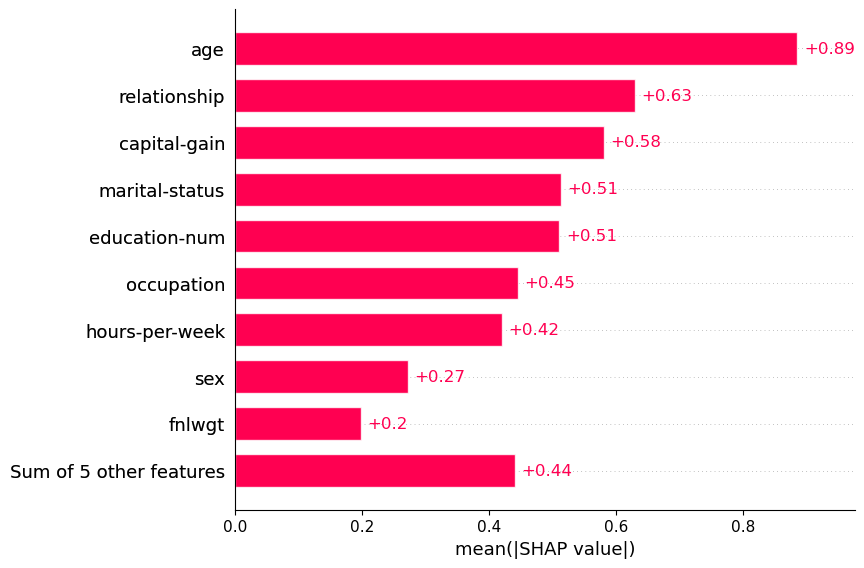

In [19]:
# Global importance for "age".
print(np.mean(np.abs(shap_values.values[:,0])))
# Bar plot showing global importance of all features.
shap.plots.bar(shap_values);

These scores can also be thought of similar to feature_importances in sklearn. However, as the following scores show, there are important differences.

**Question:** What might be the explanation of this difference and which one is better?


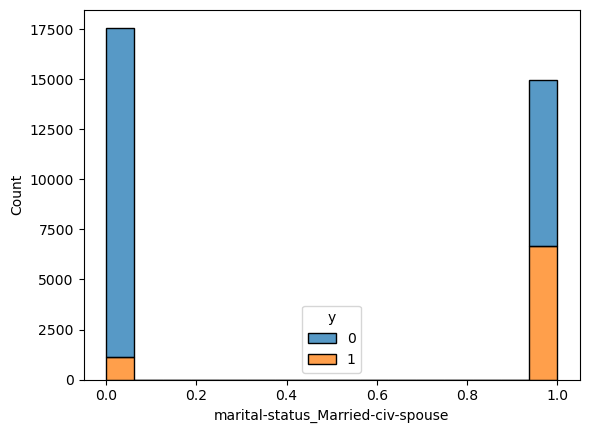

In [38]:
sns.histplot(data=ohe_encoded, x="marital-status_Married-civ-spouse", hue="y", multiple="stack");

**Question** In the above figure we can see that being married increases the chance of being 1 (>=50k). Also in the shap chart, we see that, being married has the highest positive. Can there be cases where these differ substantially? What value shap adds on top of these univariate feature importances?

In [20]:
#importance_dict = xgb_model.get_booster().get_score(importance_type='gain')
importance_dict = dict(zip(xgb_model.feature_names_in_, xgb_model.feature_importances_))
importance_df = pd.DataFrame(importance_dict.items(), columns=['Feature', 'Importance'])

# Sort the dataframe in decreasing order of importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df

,Feature,Importance
7,relationship,0.367383
10,capital-gain,0.143573
4,education-num,0.131976
5,marital-status,0.099038
11,capital-loss,0.060679
9,sex,0.034152
0,age,0.032486
6,occupation,0.031091
12,hours-per-week,0.027764
1,workclass,0.017727


### beeswarm Plot

This plot shows individual shap values of each feature, it also colors individual shap values with respect to the feature values. In this way, it is possible to see the relationship between feature values and the shapley values. Note that for categorical features care must be taken. If you label encode the categorical features than you should pay attention to which numbers correspond to which feature values. By default the feature values are numbered in sorted order in most packages. Another alternative is to one-hot encode the categorical features. The adult dataset in the shap package is label encoded.

In [16]:
X1, y1 = shap.datasets.adult()
X1

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27.0,4,12.0,2,13,5,4,0,0.0,0.0,38.0,39
32557,40.0,4,9.0,2,7,4,4,1,0.0,0.0,40.0,39
32558,58.0,4,9.0,6,1,1,4,0,0.0,0.0,40.0,39
32559,22.0,4,9.0,4,1,3,4,1,0.0,0.0,20.0,39


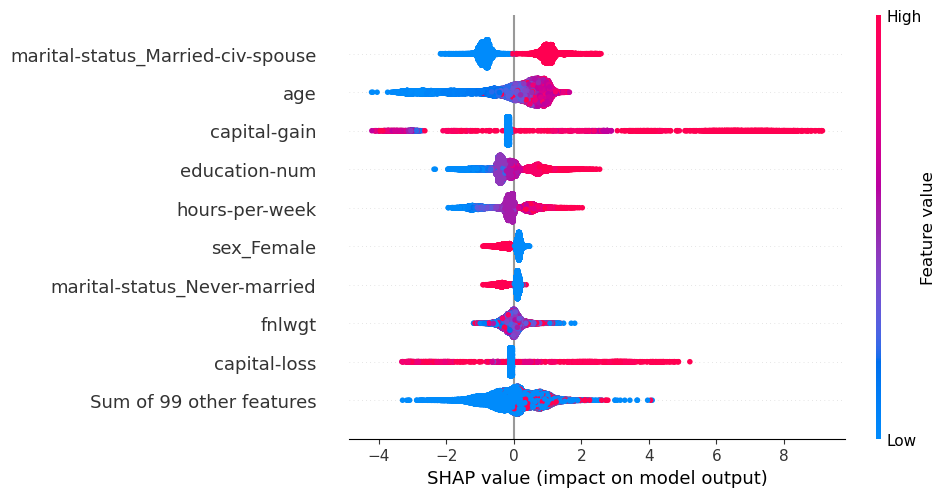

In [17]:
shap.plots.beeswarm(shap_values);

As can be seen in the above figure, the model tends to predict older people are more likely to have higher incomes, since the shap values of red points tend to have larger shap values. Note that in the dataset <50k and >50k is encoded as 0 and 1, respectively.

### Local Bar Plot

This plot shows the shap values for an individual sample.

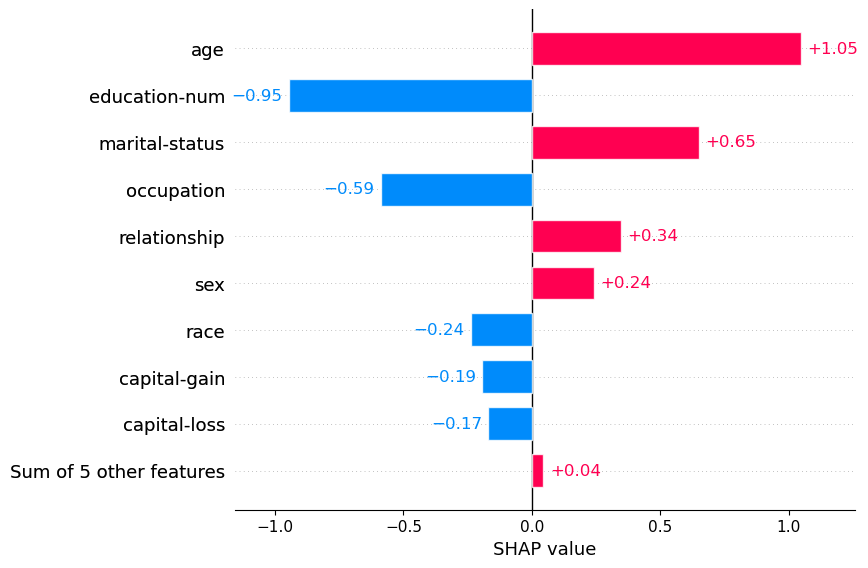

In [19]:
shap.plots.bar(shap_values[3]);

### Waterfall

In [23]:
print(y.value_counts())
a = 7841
b = 24720
print(np.log(a/(a+b)/(b/(a+b))))

y
0.0    24720
1.0     7841
Name: count, dtype: int64
-1.148246255340705


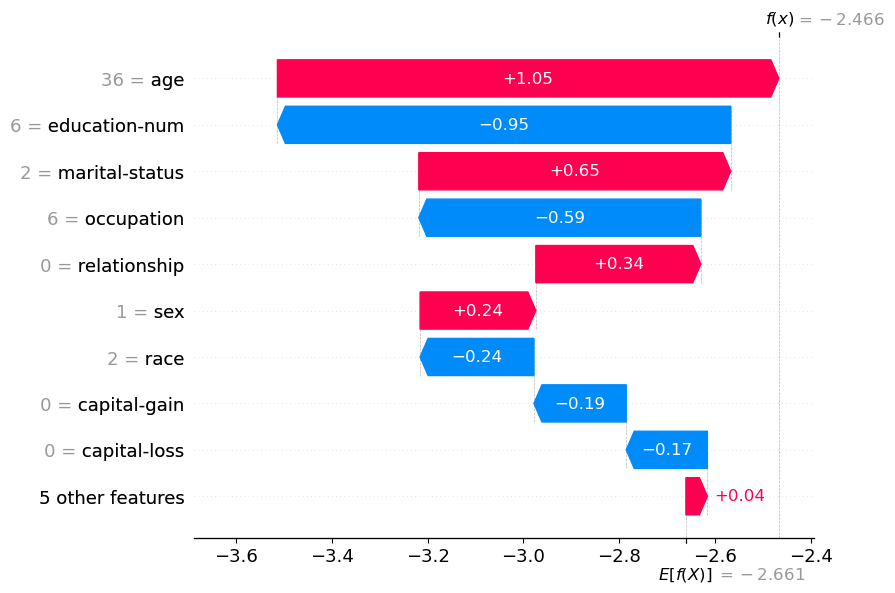

In [20]:
shap.plots.waterfall(shap_values[3])


In [15]:
shap.initjs()
shap.plots.force(shap_values[10])

In [16]:
shap.plots.force(shap_values[:100])

### Cohort Bar Plot

cohorts() takes int or array. From the doc:
If this is an integer then we auto build that many cohorts using a decision tree. If this is an array then we treat that as an array of cohort names/ids for each instance.

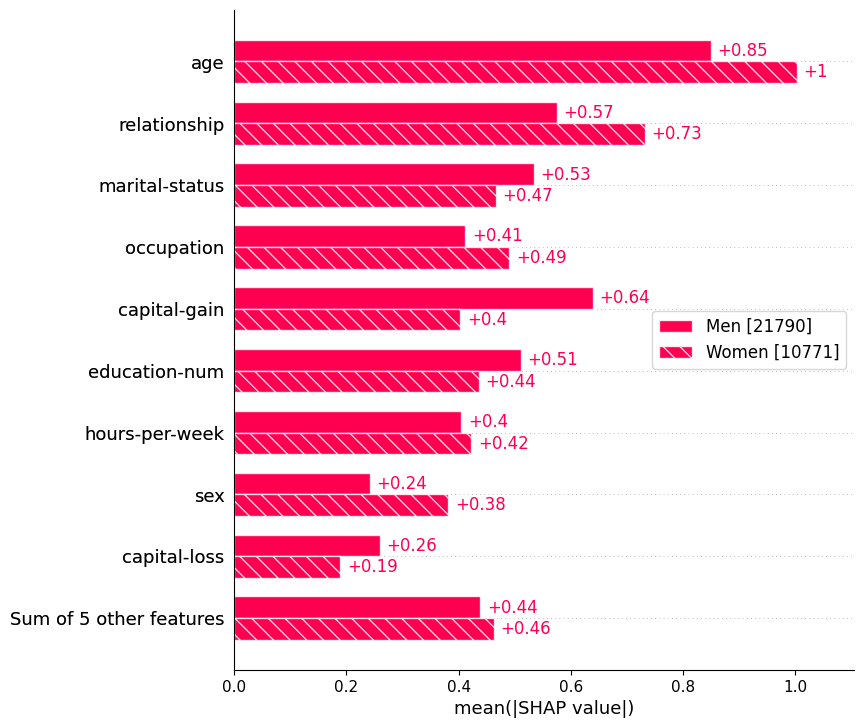

In [29]:
sex = ["Women" if shap_values[i,"sex"].data == 0 else "Men" for i in range(shap_values.shape[0])]
shap.plots.bar(shap_values.cohorts(sex).abs.mean(0))

### Abalone Dataset


In [3]:
abalone = pd.read_csv("../datasets/abalone/abalone.data",
                  names=["sex","length","diameter","height",
                         "whole weight","shucked weight",
                         "viscera weight","shell weight",
                         "rings"])
                         
#Get features
y = abalone['rings']
X = abalone[["sex","length","height",
          "shucked weight","viscera weight","shell weight"]].copy()
abalone[:11]

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
5,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8
6,F,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20
7,F,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.260,16
8,M,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.165,9
9,F,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.320,19


In [9]:
X = pd.get_dummies(X).astype({'sex_F': int, 'sex_I': int, 'sex_M': int})
X

,length,height,shucked weight,viscera weight,shell weight,sex_F,sex_I,sex_M
0,0.455,0.095,0.2245,0.1010,0.1500,0,0,1
1,0.350,0.090,0.0995,0.0485,0.0700,0,0,1
2,0.530,0.135,0.2565,0.1415,0.2100,1,0,0
3,0.440,0.125,0.2155,0.1140,0.1550,0,0,1
4,0.330,0.080,0.0895,0.0395,0.0550,0,1,0
...,...,...,...,...,...,...,...,...
4172,0.565,0.165,0.3700,0.2390,0.2490,1,0,0
4173,0.590,0.135,0.4390,0.2145,0.2605,0,0,1
4174,0.600,0.205,0.5255,0.2875,0.3080,0,0,1
4175,0.625,0.150,0.5310,0.2610,0.2960,1,0,0


In [10]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)
xgb_model = xgboost.XGBRegressor().fit(X_train, y_train)

y_pred = dt_model.predict(X_test)  
print("Decision Tree")
print(mean_absolute_error(y_test,y_pred))
y_pred = xgb_model.predict(X_test)  
print("XGBoost")
print(mean_absolute_error(y_test,y_pred))

Decision Tree
2.2033492822966507
XGBoost
1.7517274515480517


In [11]:
xgb_model = xgboost.XGBRegressor(objective="reg:squarederror").fit(X, y)
#gb_model = GradientBoostingClassifier().fit(X,y)
dt_model = DecisionTreeRegressor(min_samples_split=20).fit(X,y)

explainer = shap.Explainer(xgb_model, X)
shap_values = explainer(X)

 94%|=================== | 3922/4177 [00:12<00:00]       

In [77]:
shap_values.base_values

array([10.73543809, 10.73543809, 10.73543809, ..., 10.73543809,
       10.73543809, 10.73543809])

In [78]:
shap_values_sampling = []
for i in range(X.shape[1]):
    feature_name, value = shapley_value_by_sampling(xgb_model, X, 10, i)
    print(feature_name, value)
    shap_values_sampling.append(value)


length [0.19537218]
height [0.5924347]
shucked weight [1.5607923]
viscera weight [-0.07151753]
shell weight [0.18891972]
sex.M [-0.03044518]
sex.F [0.20819959]
sex.I [0.26466334]


### Visualizations

Using this table of values we can plot different figures.

### Global Bar Plot

Each feature's global importance is calculated as the mean of the absolute shap values of that feature over all samples. An example calculation is given below.

**Question:** Why is mean of the absolute values used but not just the mean value?

0.6060107961120224


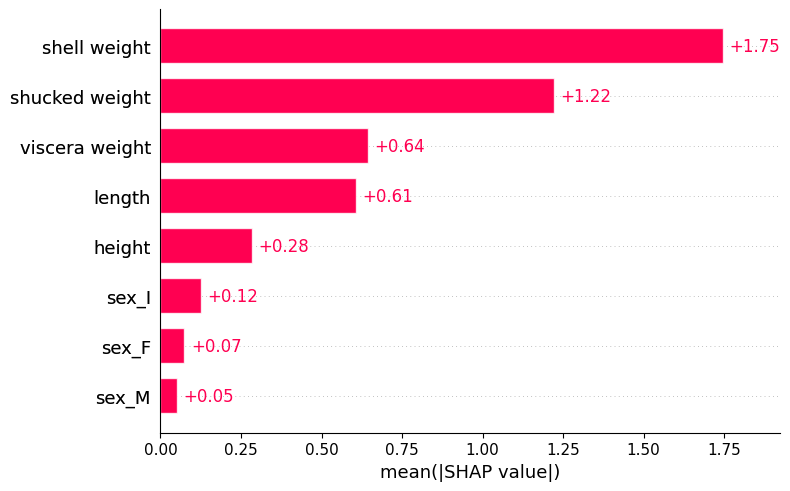

In [12]:
# Global importance for "shell weight".
print(np.mean(np.abs(shap_values.values[:,0])))
# Bar plot showing global importance of all features.
shap.plots.bar(shap_values);

These scores can also be thought of similar to feature_importances in sklearn. However, as the following scores show, there are important differences.

**Question:** What might be the explanation of this difference and which one is better?

In [13]:
#importance_dict = xgb_model.get_booster().get_score(importance_type='gain')
importance_dict = dict(zip(dt_model.feature_names_in_, dt_model.feature_importances_))
importance_df = pd.DataFrame(importance_dict.items(), columns=['Feature', 'Importance'])

# Sort the dataframe in decreasing order of importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df

,Feature,Importance
4,shell weight,0.640046
2,shucked weight,0.194005
0,length,0.047965
3,viscera weight,0.046618
1,height,0.040367
6,sex_I,0.021731
5,sex_F,0.004772
7,sex_M,0.004496


### Local Bar Plot

This plot shows the shap values for an individual sample.

**Question:** If the shapley value of a feature is different between two instances, what might be the explanation?

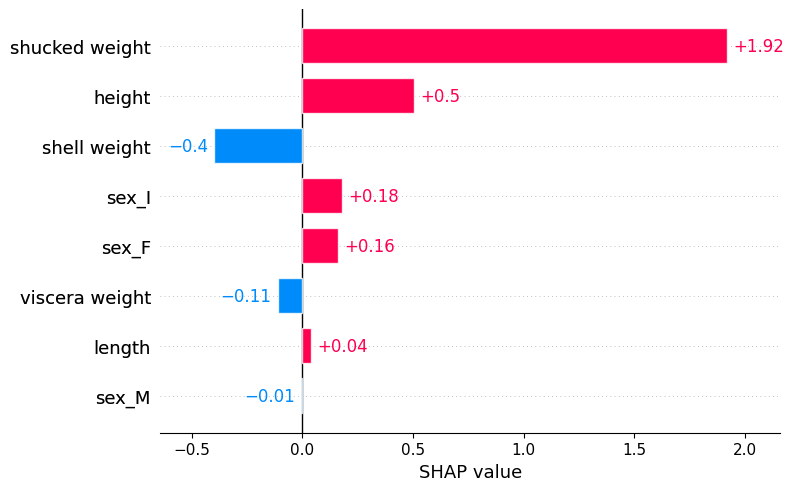

In [14]:
shap.plots.bar(shap_values[10]);

### Waterfall Plot

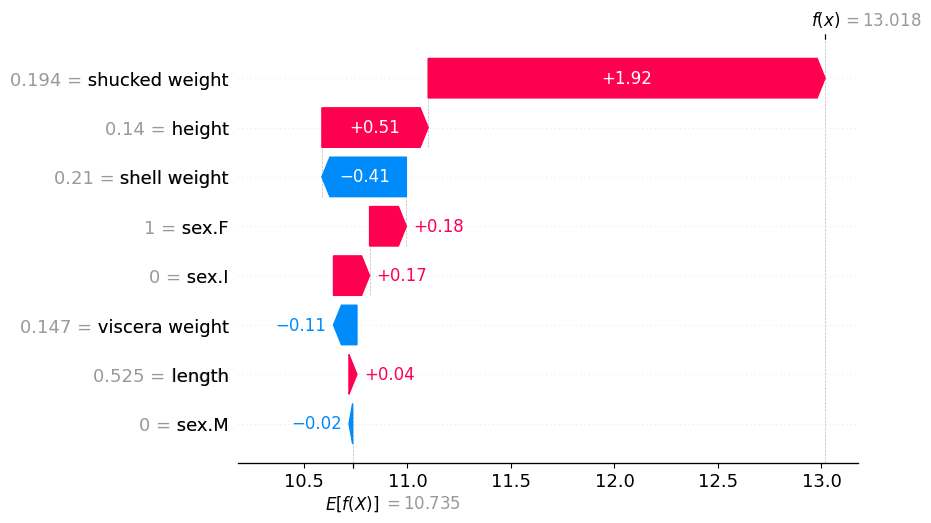

In [80]:
shap.plots.waterfall(shap_values[10]);

### beeswarm Plot

This plot shows individual shap values of each feature, it also colors individual shap values with respect to the feature values. In this way, it is possible to see the relationship between feature values and the shapley values. Note that for categorical features care must be taken. If you label encode the categorical features than you should pay attention to which numbers correspond to which feature values. By default the feature values are numbered in sorted order in most packages. Another alternative is to one-hot encode the categorical features. The adult dataset in the shap package is label encoded.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


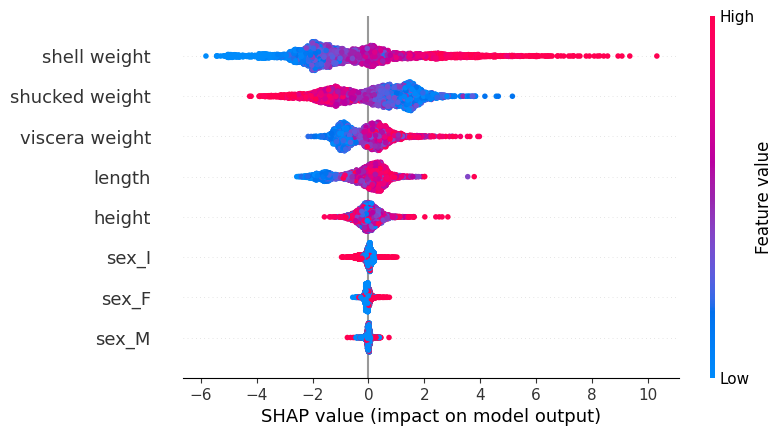

In [15]:
shap.plots.beeswarm(shap_values);

In [83]:
shap.plots.force(shap_values[0])

In [16]:
shap.plots.force(shap_values[0:100])

### California Housing Dataset

In [37]:
from sklearn.datasets import fetch_california_housing

X, y = fetch_california_housing(return_X_y=True, as_frame=True)

In [23]:
X

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)
xgb_model = xgboost.XGBRegressor().fit(X_train, y_train)

y_pred = dt_model.predict(X_test)  
print("Decision Tree")
print(mean_absolute_error(y_test,y_pred))
y_pred = xgb_model.predict(X_test)  
print("XGBoost")
print(mean_absolute_error(y_test,y_pred))

Decision Tree
0.46323735465116284
XGBoost
0.301328921032079


In [39]:
xgb_model = xgboost.XGBRegressor().fit(X, y)
#gb_model = GradientBoostingClassifier().fit(X,y)
#dt_model = DecisionTreeRegressor(min_samples_split=20).fit(X,y)
X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution

explainer = shap.Explainer(xgb_model, X)
shap_values = explainer(X)

100%|===================| 20592/20640 [01:29<00:00]        

0.339204462120771


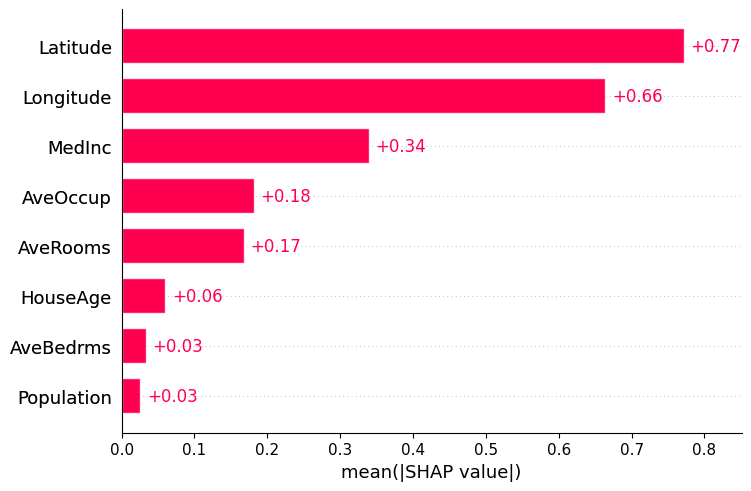

In [40]:
# Global importance for "MedInc".
print(np.mean(np.abs(shap_values.values[:,0])))
# Bar plot showing global importance of all features.
shap.plots.bar(shap_values);

Two different models, with the same error, but with different shapley values? 

In [34]:
#importance_dict = xgb_model.get_booster().get_score(importance_type='gain')
importance_dict = dict(zip(xgb_model.feature_names_in_, xgb_model.feature_importances_))
importance_df = pd.DataFrame(importance_dict.items(), columns=['Feature', 'Importance'])

# Sort the dataframe in decreasing order of importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df

,Feature,Importance
0,MedInc,0.469949
5,AveOccup,0.147673
7,Longitude,0.116059
6,Latitude,0.098304
1,HouseAge,0.073442
2,AveRooms,0.045287
4,Population,0.025611
3,AveBedrms,0.023676


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


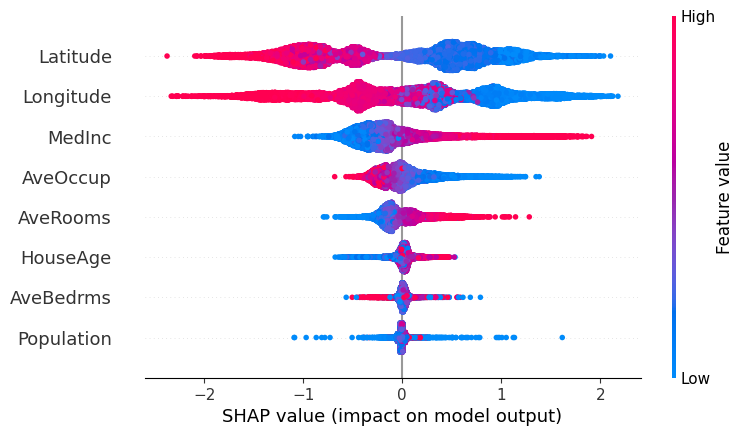

In [27]:
shap.plots.beeswarm(shap_values);

### APPENDIX

### Efficiency Property

